In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
sns.set_context('talk')

import model

%load_ext autoreload
%autoreload 2

Let's test out whether the BNP method works for fitting the traditionally "difficult" exponential mixture datasets referenced in earlier publications

* Exponential Sum-Fitting of Dwell-Time Distributions without Specifying Starting Parameters -- 10^7 data points
* Single molecule force spectroscopy at high data acquisition: A Bayesian nonparametric analysis -- 10^4 data points

In [25]:
import scipy.stats

BOLIDEN_3 = dict(
    ps=np.array([0.750298, 0.174148, 0.058784, 0.016770]),
    taus=np.array([142.8367, 9.463603, 1.362166, 0.1])
)

BOLIDEN_4 = dict(
    ps=np.array([0.728129, 0.128014, 0.052813, 0.091044]),
    taus=np.array([196.5023, 6.839898, 1.422491, 0.287471])
)

PAF_1 = dict(
    ps=np.array([0.594, 0.266, 0.140]),
    taus=np.array([400.079, 119.566, 35.451])
)

SIMPLE = dict(
    ps = [1],
    taus = [10]
)

def get_param_summary_df(ps, taus):
    k = len(ps)
    df = pd.DataFrame(index=['truth'], dtype=float)
    for i in range(k):
        df['tau_%d'%i] = taus[i]
    for i in range(k):
        df['p_%d'%i] = ps[i]
    return df

def generate_simulated_dataset(ps, taus, N, M, tc=480, correct_ps=True):
    assert(len(ps) == len(taus))
    if correct_ps:
        ps = ps/np.sum(ps)
    K = len(ps)

    # Class of each bead
    classes_actual = np.random.choice(np.arange(K), size=N, p=ps)

    # Observed times
    times = np.zeros((N,M))
    for i in range(N):
        tau = taus[classes_actual[i]]
        times[i,:] = np.random.exponential(scale=tau, size=M)
        # times[i,:] = scipy.stats.truncexpon.rvs(tau/tc, size=M) * tc
    
    times[times > tc] = np.nan
    
    return times

def mixture_pdf(xs, ps, taus, m=1):
    ys = np.zeros_like(xs)
    for i in range(len(ps)):
        ys += ps[i] * gamma_pdf(xs, taus[i], m) 
    return ys

def gamma_pdf(xs, tau, m=1):
    # return (1/tau) * np.exp(-xs / tau)
    return scipy.stats.gamma.pdf(xs, a=m, scale=tau/m)

def plot_dataset_and_density(ts, ps, taus, num_repeats=[1,3,9], components=True, bins=np.logspace(-2, 3.5, 100), title=''):
    fig, axes = plt.subplots(3, 1, figsize=(8,8), sharex=True)

    N,M_max = ts.shape
    jacobian = bins * np.log(10)
    bin_width = np.log10(bins[2] / bins[1])

    for i,ax in enumerate(axes):
        M = num_repeats[i]
        ts_here = ts[:,:M]
        if len(ts_here.shape) == 1:
            ts_here = np.array([ts_here])
        label = 'no averaging' if M == 0 else '%d repeats' % M

        y_factor =  jacobian * N * bin_width

        if components:
            for p,tau in zip(ps, taus):
                ax.plot(bins, p * gamma_pdf(bins, tau, m=M) * y_factor, lw=2)

            ax.plot(bins, mixture_pdf(bins, ps, taus, m=M) * y_factor, color='k', alpha=0.5)

        ax.hist(np.nanmean(ts_here, axis=1), bins=bins, color='gray')

        ax.set_xscale('log')
        if i == 1:
            ax.set_xlabel('time')
        ax.set_ylabel('counts')
        ax.text(0.05, 0.9, label, ha='left', va='top', transform=ax.transAxes)

    fig.suptitle(title)
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, ax

def compare_truth_and_posterior(traj, k, params):
    fig, axes = plt.subplots(2, k, figsize=(4*k, 5))

    traj = traj[traj['K'] == k]
    for i in range(k):
        axes[0][i].hist(traj['relabeled_tau_%d'%i], 
                        bins=20, facecolor='white', edgecolor='k', lw=2)
        axes[0][i].axvline(params['taus'][i], color='red')
        axes[1][i].hist(traj['relabeled_p_%d'%i], 
                        bins=20, facecolor='white', edgecolor='k', lw=2)
        axes[1][i].axvline(params['ps'][i], color='red')
    plt.tight_layout()
    return fig, axes


/tmp/ipykernel_153/2655101287.py:84: RuntimeWarning: Mean of empty slice
  ax.hist(np.nanmean(ts_here, axis=1), bins=bins, color='gray')


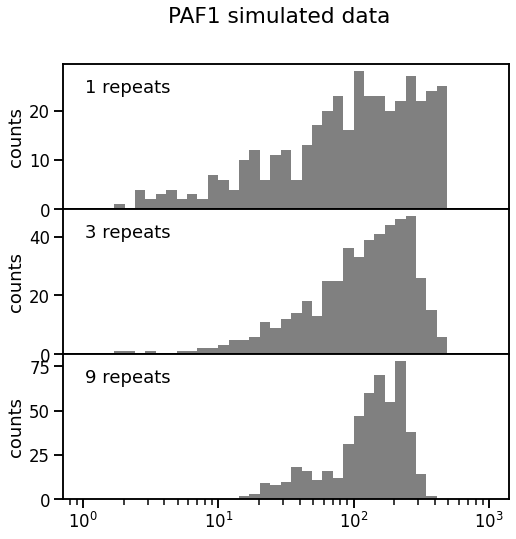

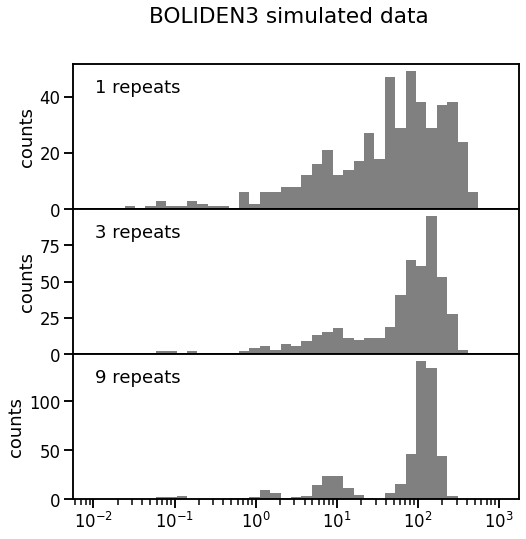

In [27]:
np.random.seed(44)
ts_paf = generate_simulated_dataset(N=500, M=20, **PAF_1)
ts_boliden = generate_simulated_dataset(N=500, M=20, **BOLIDEN_3)

plot_dataset_and_density(ts_paf, bins=np.logspace(0, 3, 40), components=False, title='PAF1 simulated data', **PAF_1);
plot_dataset_and_density(ts_boliden, bins=np.logspace(-2, 3, 40), components=False, title='BOLIDEN3 simulated data', **PAF_1);

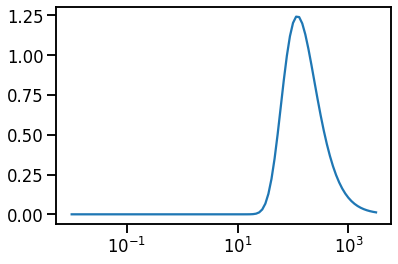

In [7]:
model.plot_inv_gamma_prior(2, 240)

## Try fitting a 10000 by 1 table

In [33]:
M = 1
fitter = model.BNPFitter(pd.DataFrame(ts_paf.reshape(-1)), a_tau_hp=2, b_tau_hp=240, fixed_gamma=0.001, do_truncation=True, t_censor=480)
traj = fitter.fit(num_iterations=30000)

/mnt/c/Users/jeffj/Documents/lab/wong-rotation/data/yi-prelim/Antibody_CFM_analysis/model.py:213: RuntimeWarning: divide by zero encountered in log
  return np.log(np.random.dirichlet(alphas))


  0%|          | 0/30000 [00:00<?, ?it/s]

(<Figure size 1080x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Proportions\nof species'>,
        <AxesSubplot:ylabel='Lifetime of\nspecies (s)'>,
        <AxesSubplot:ylabel='Number of\ncomponents'>,
        <AxesSubplot:xlabel='MC iteration number', ylabel='Log posterior\n(unnormalized)'>],
       dtype=object))

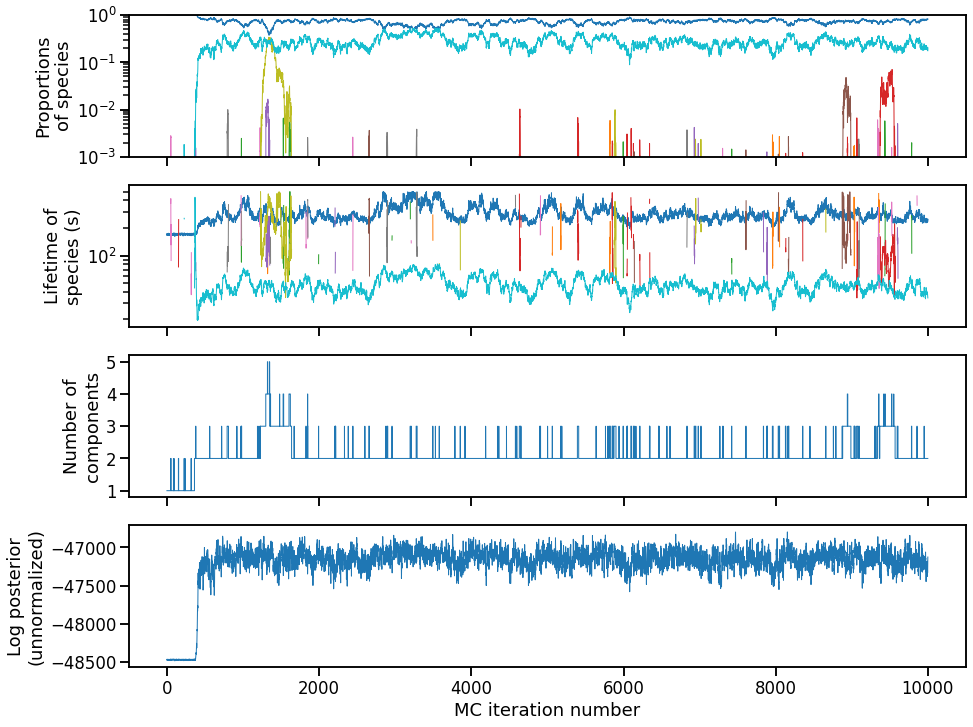

In [30]:
model.plot_trajectories(traj, log_lifetimes=True, log_proportions=True)

In [31]:
pd.concat(
    [ get_param_summary_df(**PAF_1),
      model.get_param_summary(traj, k=3)
    ]
)


,tau_0,tau_1,tau_2,p_0,p_1,p_2
truth,400.079000,119.566000,35.451000,0.594000,0.266000,0.140000
mean,300.332387,156.485432,46.212863,0.589941,0.155626,0.254421
std,58.636704,75.534764,8.910189,0.263089,0.271791,0.074661


(<Figure size 864x360 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

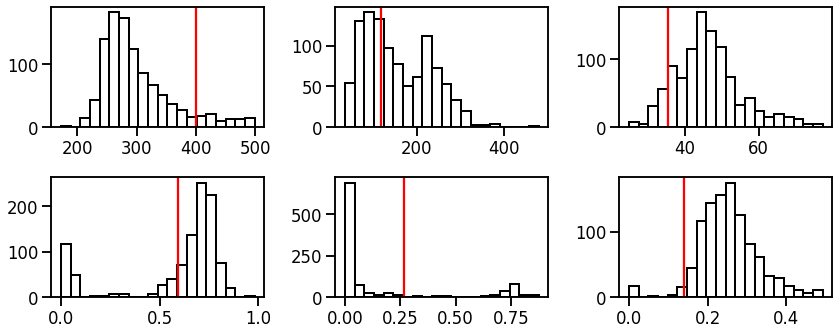

In [32]:
compare_truth_and_posterior(traj, 3, PAF_1)

## And now try a 1000 by 10 table

In [61]:
# ts_to_fit = pd.DataFrame(ts).iloc[:1000,:10]
fitter = model.BNPFitter(pd.DataFrame(ts), a_tau_hp=2, b_tau_hp=240, fixed_gamma=0.001, do_truncation=True, t_censor=480)
traj = fitter.fit(num_iterations=10000)

/mnt/c/Users/jeffj/Documents/lab/wong-rotation/data/yi-prelim/Antibody_CFM_analysis/model.py:213: RuntimeWarning: divide by zero encountered in log
  return np.log(np.random.dirichlet(alphas))


  0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 1080x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Proportions\nof species'>,
        <AxesSubplot:ylabel='Lifetime of\nspecies (s)'>,
        <AxesSubplot:ylabel='Number of\ncomponents'>,
        <AxesSubplot:xlabel='MC iteration number', ylabel='Log posterior\n(unnormalized)'>],
       dtype=object))

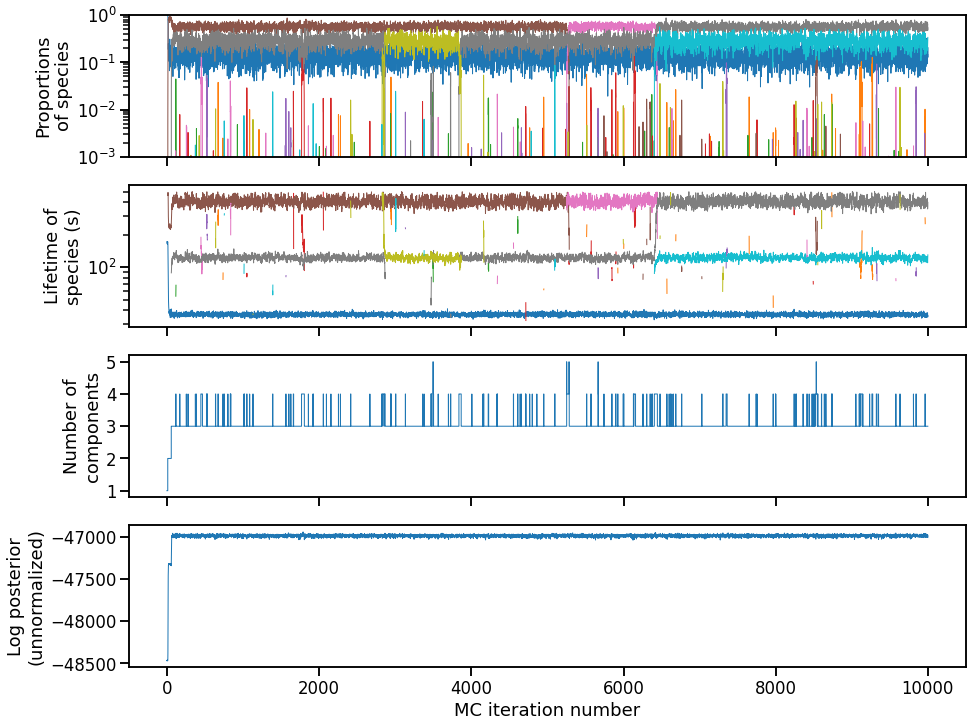

In [62]:
model.plot_trajectories(traj, log_lifetimes=True, log_proportions=True)

In [63]:
pd.concat(
    [ get_param_summary_df(**PAF_1),
      model.get_param_summary(traj, k=3)
    ]
)


,tau_0,tau_1,tau_2,p_0,p_1,p_2
truth,400.079000,119.566000,35.451000,0.594000,0.266000,0.140000
mean,403.510680,122.435179,36.489317,0.566949,0.287671,0.145197
std,31.977914,5.849929,1.092490,0.076198,0.071535,0.049295


# BOLIDEN

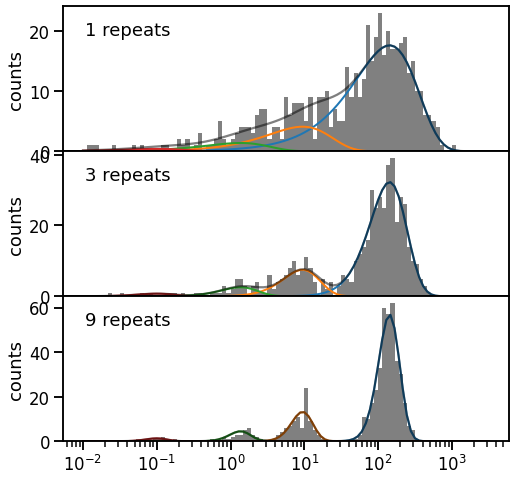

In [11]:
np.random.seed(44)
ts = generate_simulated_dataset(N=500, M=20, tc=1e8, **BOLIDEN_3)
plot_dataset_and_density(ts, **BOLIDEN_3);

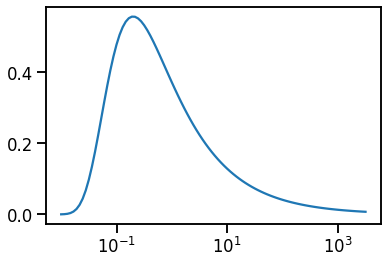

In [12]:
model.plot_inv_gamma_prior(0.5, 0.1)

## Try fitting a 10000 by 1 table

In [34]:
M = 1
fitter = model.BNPFitter(pd.DataFrame(ts_boliden.reshape(-1)), a_tau_hp=0.5, b_tau_hp=0.1, fixed_gamma=0.001, do_truncation=False)
traj = fitter.fit(num_iterations=30000)

  0%|          | 0/30000 [00:00<?, ?it/s]

(<Figure size 1080x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Proportions\nof species'>,
        <AxesSubplot:ylabel='Lifetime of\nspecies (s)'>,
        <AxesSubplot:ylabel='Number of\ncomponents'>,
        <AxesSubplot:xlabel='MC iteration number', ylabel='Log posterior\n(unnormalized)'>],
       dtype=object))

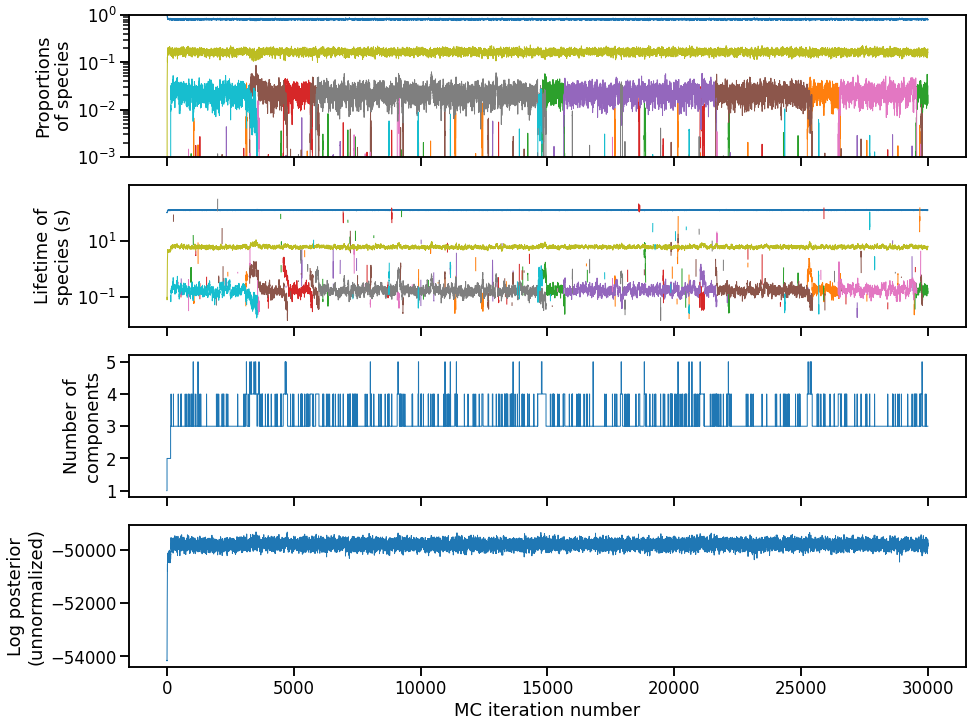

In [35]:
model.plot_trajectories(traj, log_lifetimes=True, log_proportions=True)

In [36]:
pd.concat(
    [ get_param_summary_df(**BOLIDEN_3),
      model.get_param_summary(traj, k=4)
    ]
)


,tau_0,tau_1,tau_2,tau_3,p_0,p_1,p_2,p_3
truth,142.836700,9.463603,1.362166,0.100000,0.750298,0.174148,0.058784,0.016770
mean,120.152074,9.808404,1.081250,0.117243,0.796467,0.162555,0.028067,0.012906
std,9.354345,17.416077,1.509734,0.063973,0.099481,0.089068,0.039549,0.008898


(<Figure size 1152x360 with 8 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

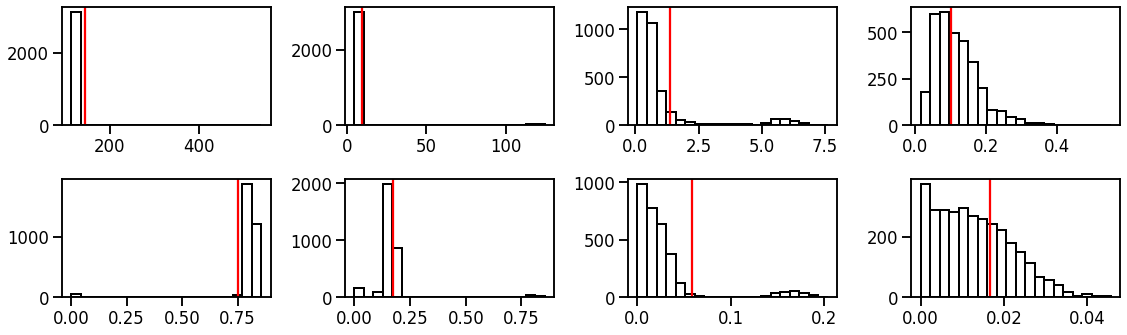

In [37]:
compare_truth_and_posterior(traj, 4, BOLIDEN_3)

## And now try a 500 by 20 table

In [17]:
fitter = model.BNPFitter(pd.DataFrame(ts), a_tau_hp=0.5, b_tau_hp=0.1, fixed_gamma=0.001, do_truncation=False)
traj = fitter.fit(num_iterations=30000)

/mnt/c/Users/jeffj/Documents/lab/wong-rotation/data/yi-prelim/Antibody_CFM_analysis/model.py:213: RuntimeWarning: divide by zero encountered in log
  return np.log(np.random.dirichlet(alphas))


  0%|          | 0/30000 [00:00<?, ?it/s]

(<Figure size 1080x864 with 4 Axes>,
 array([<AxesSubplot:ylabel='Proportions\nof species'>,
        <AxesSubplot:ylabel='Lifetime of\nspecies (s)'>,
        <AxesSubplot:ylabel='Number of\ncomponents'>,
        <AxesSubplot:xlabel='MC iteration number', ylabel='Log posterior\n(unnormalized)'>],
       dtype=object))

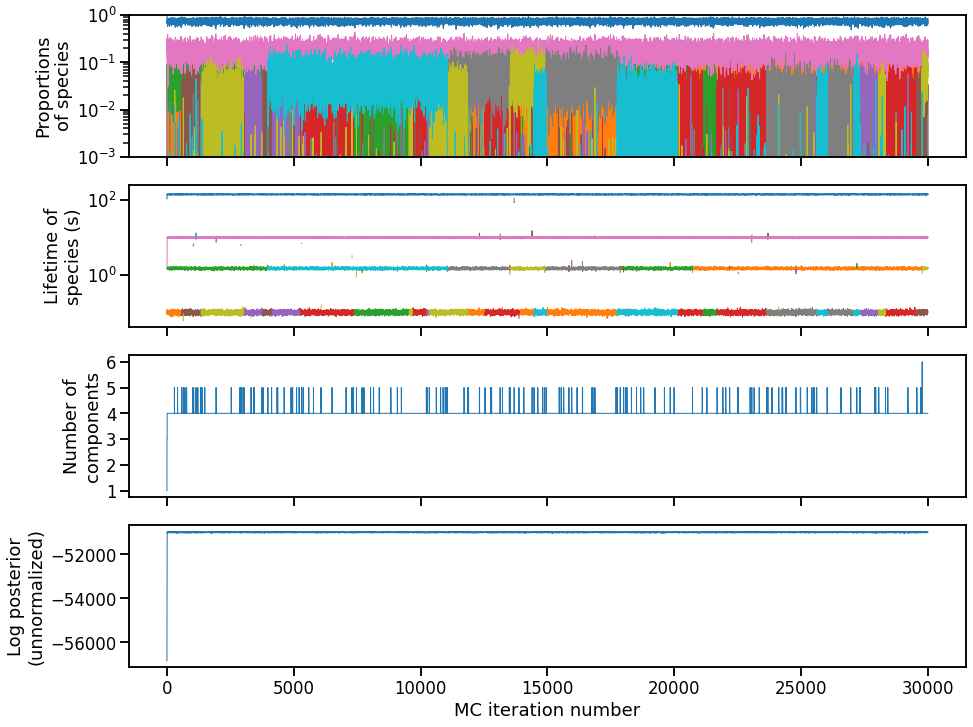

In [18]:
model.plot_trajectories(traj, log_lifetimes=True, log_proportions=True)

In [19]:
pd.concat(
    [ get_param_summary_df(**BOLIDEN_3),
      model.get_param_summary(traj, k=4)
    ]
)


,tau_0,tau_1,tau_2,tau_3,p_0,p_1,p_2,p_3
truth,142.836700,9.463603,1.362166,0.100000,0.750298,0.174148,0.058784,0.016770
mean,142.063669,9.821550,1.454795,0.095396,0.747851,0.177861,0.058058,0.016090
std,1.646542,0.232582,0.060617,0.007572,0.060977,0.053617,0.032635,0.017651


(<Figure size 1152x360 with 8 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

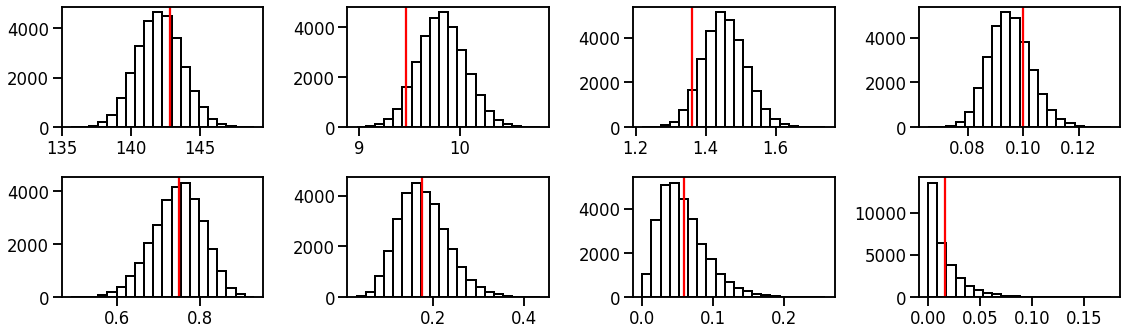

In [20]:
compare_truth_and_posterior(traj, 4, BOLIDEN_3)

Fascinating -- comparing the 10000 x 1 vs the 500 x 20 data table:
* very clearly 4 clusters
* uncertainty in the lifetime is greatly reduced
* but the uncertainty in the proportion is increased (makes sense just on acct of binomial statistics --- fewer # beads)